In [4]:
import jax.numpy as jnp
from jax import grad, jit, value_and_grad, vmap, random, tree_map
from jax.lax import scan
from jax.nn import softplus
from jax.nn.initializers import glorot_normal
from jax.numpy.linalg import norm

import matplotlib.pyplot as plt
from tqdm import tqdm

%config InlineBackend.figure_formats = ['svg']
key = random.PRNGKey(1)

# Physics-Informed Neural Networks

*Physics-Informed Neural Networks* (PINNs) refer to an approach for solving ODEs and PDEs that does not use discretization schemes such as finite differences, elements or volumes.
Instead a NN is used as a map from time and spatial coordinates to the solution at the given time $N(t,x,y) \sim u(t,x,y)$.

A common choice of network architecture is a *Multi-Layer Perceptron* (MLP).
The "physics-informed" aspect of the model comes from the fact that the equations governing the system are used to regularize the solution of the network during training.

The strongest motivation for using PINNs comes from the fact that defining the governing equations of a PDE is typically much simpler than producing the solution.

100%|██████████| 1000/1000 [00:21<00:00, 45.88it/s]


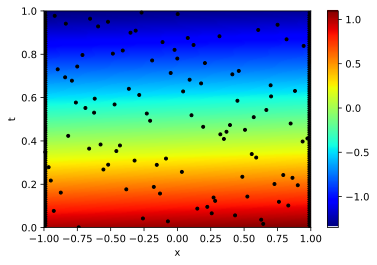

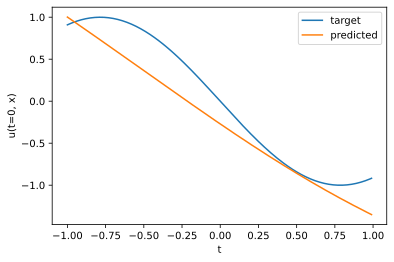

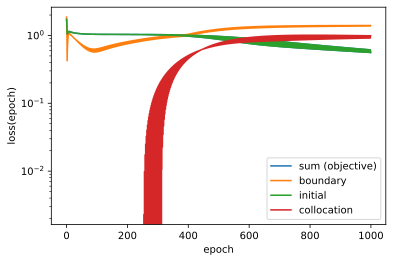

In [58]:
from scipy.stats.qmc import LatinHypercube


n_epochs = 1000
lr = 0.001
losses = {"loss": [], "loss_boundary": [], "loss_initial": [], "loss_collocation" : []}

t_begin = 0.0
t_end = 1.0
x_begin = -1.0
x_end = 1.0
x_res = 0.01
t_res = 0.01
t = jnp.arange(t_begin, t_end, x_res)
x = jnp.arange(x_begin, x_end, t_res)
u_initial = -jnp.sin(2*x)

t_collocation, x_collocation = (
    jnp.array(LatinHypercube(d=2).random(100))
    * jnp.array((t_end - t_begin, x_end - x_begin))
    + jnp.array((t_begin, x_begin))
).T


def predict(t, x, params):
    *hidden, last = params
    x = jnp.array((t, x))
    for layer in hidden:
        x = softplus(x @ layer["weights"] + layer["biases"])
    return (x @ last["weights"] + last["biases"]).squeeze(-1)


def init_mlp_params(layer_widths, key):
    params = []
    k1, k2 = random.split(key)
    initializer = glorot_normal()
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            {
                "weights": initializer(k1, (n_in, n_out)),
                "biases": initializer(k2, (n_out, 1)).reshape(-1),
            }
        )
    return params


def loss(params):

    predict_vmap = vmap(predict, (0, None, None))
    u_begin = predict_vmap(t, x_begin, params)
    u_end = predict_vmap(t, x_end, params)
    loss_boundary = norm(u_begin - 0.0) + norm(u_end - 0.0)

    u = vmap(predict, (0, 0, None))(t_collocation, x_collocation, params)
    ut = vmap(grad(predict), (0, 0, None))(t_collocation, x_collocation, params)
    ux = vmap(grad(predict, argnums=1), (0, 0, None))(
        t_collocation, x_collocation, params
    )
    uxx = vmap(grad(grad(predict, argnums=1), argnums=1), (0, 0, None))(
        t_collocation, x_collocation, params
    )
    u_initial_predicted = vmap(predict, (None, 0, None))(0.0, x, params)
    loss_initial = norm(u_initial - u_initial_predicted)

    loss_collocation = norm(ut + u * ux - (0.01 / jnp.pi) * uxx)

    return loss_initial, (
        loss_initial,
        loss_boundary,
        loss_collocation,
    )


def update(params):
    ((value, (loss_initial, loss_boundary, loss_collocation)), grads) = value_and_grad(
        loss, has_aux=True
    )(params)
    params = tree_map(lambda p, g: p - lr * g, params, grads)
    return (value, loss_initial, loss_boundary, loss_collocation), params


params = init_mlp_params([2, 64, 64, 64,64,64, 1], key)

update_jit = jit(update)

for _ in tqdm(range(n_epochs)):
    (value, loss_initial, loss_boundary, loss_collocation), params = update_jit(params)
    losses["loss"].append(value)
    losses["loss_initial"].append(loss_initial)
    losses["loss_boundary"].append(loss_boundary)
    losses["loss_collocation"].append(loss_collocation)


tt, xx = jnp.meshgrid(t, x)

u = vmap(predict, (0, 0, None))
u = vmap(u, (0, 0, None))
uu = u(tt, xx, params)

fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.scatter(jnp.ones_like(t) * x_begin, t, marker="x", color="black")  # boundary begin
ax.scatter(jnp.ones_like(t) * x_end, t, marker="x", color="black")  # boundary end
ax.scatter(
    x_collocation, t_collocation, marker=".", color="black"
)  # collocation points


cmap = ax.imshow(
    uu,
    cmap="jet",
    extent=[x_begin, x_end, t_begin, t_end],
    origin="lower",
    aspect="auto",
)
plt.colorbar(cmap)

fig, ax = plt.subplots()
ax.plot(x, u_initial, label="target")
ax.plot(x, vmap(predict, (None, 0, None))(0.0, x, params), label="predicted")
ax.set_xlabel("t")
ax.set_ylabel("u(t=0, x)")
ax.legend()


fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot((jnp.array(jnp.log10(jnp.array(losses["loss"])))), label="sum (objective)")
ax.plot((jnp.array(jnp.log10(jnp.array(losses["loss_boundary"])))), label="boundary")
ax.plot((jnp.array(jnp.log10(jnp.array(losses["loss_initial"])))), label="initial")
ax.plot((jnp.array(jnp.log10(jnp.array(losses["loss_collocation"])))), label="collocation")

ax.set_xlabel("epoch")
ax.set_ylabel("loss(epoch)")
ax.legend()


In [57]:
def update(params):
    return params


DeviceArray(-0.8881284, dtype=float32)